# thickness calculator

## libraries

In [1]:
import skfmm
from scipy.ndimage import distance_transform_edt
from scipy.signal import convolve2d
from main import *

import pandas as pd

from tqdm import tqdm

## old euclidean method

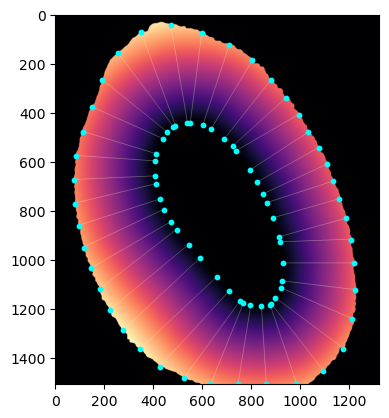

In [2]:
donut, res = get_picture2D('donut.tif')
point, _ = get_picture('point.tif')
height, width = donut.shape

donut_mask = donut != 0

# we should have only ventricle and outside regions
labeled, n = label(~ donut_mask)

if n != 2:
    raise ValueError('problem with masks, too many regions')

# outside label is the label of the pixel on the top left
outside_label = labeled[(0,0)]
outside_mask = labeled == outside_label
# ventricle is the other region
ventr_mask = (labeled != outside_label) & (~ donut_mask)

# show_pic(donut_mask, 'donut')

# calculating distance from ventricle
distance = np.zeros_like(donut, dtype=np.float64)
# keeping it only in the area of the donut
distance[donut_mask] = distance_transform_edt(~ventr_mask, sampling= res)[donut_mask]

# max value in the distance pic
max_dist = np.max(distance)

# find center of the ventricle
ventr_coords = center_of_mass(ventr_mask)

# find point in the reference pic
point_mask = point != 0
point_coords = center_of_mass(point_mask)


dx = point_coords[0] - ventr_coords[0]
dy = point_coords[1] - ventr_coords[1]
angle_0 = math.atan2(dy, dx)

max_length = np.linalg.norm(donut.shape)
# how many angles
n_angles = 40

results = pd.DataFrame(columns = ['angle_r', 'angle_d', 'thickness', 'ext_x', 'ext_y', 'vent_x', 'vent_y'])

test_img = distance.copy()

for i in range(n_angles):

    # angle of the ray
    a = 2*math.pi / n_angles * i + angle_0
    
    line_pixels = get_ray_pixels(donut, ventr_coords, a, res)

    cols = line_pixels[:,0]
    rows = line_pixels[:,1]



    # add radial picture line on top of picture
    # test_img[rows, cols] = max_dist

    # find the max ventricle distance along line
    current_thickness = np.max(distance[rows, cols])
    # where is the max distance along line
    current_index = np.argmax(distance[rows, cols])
    current_coords = [int(cols[current_index]), int(rows[current_index])]

    # circe centered in current point
    circ_pixels = get_circle_pixels(distance, current_coords, current_thickness, res)
    rows = circ_pixels[:,0]
    cols = circ_pixels[:,1]

    # add circle on top of picture
    # test_img[rows, cols] = max_dist

    # I need to set the pixels outside the tissue at some max value
    fake_distance = distance.copy()
    fake_distance[outside_mask] = max_dist
    vent_index = np.argmin(fake_distance[rows, cols])
    vent_coords = [int(cols[vent_index]), int(rows[vent_index])]

    r_line, c_line = get_line_pixels(current_coords, vent_coords)
    test_img[r_line, c_line] = max_dist

    results.loc[len(results)] = [a-angle_0, np.degrees(a-angle_0), current_thickness, *current_coords, *vent_coords]

# print(results)

plt.imshow(test_img, cmap = 'magma')
plt.scatter(results['ext_x'], results['ext_y'], s = 10, color = 'cyan')
plt.scatter(results['vent_x'], results['vent_y'], s = 10, color = 'cyan')
plt.show()

results.to_csv('result.csv')

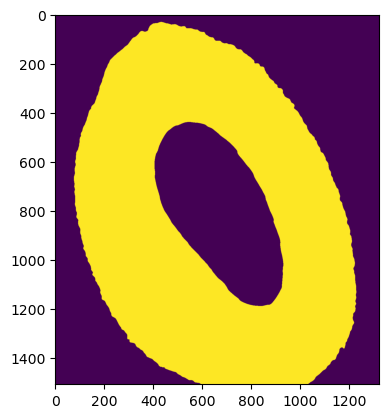

In [3]:
plt.imshow(donut)

# weird shape times 🎉

## pictures loading

In [9]:
name = 'C1-29-08-2025 E12 R1 - E4 PBS-EdU+E6 GFP - EdU 647 - GFP+HuCD 488 - SOX2 555'
# name = 'C1-29-08-2025 E12 R1 f - E4 FGF2-EdU+E6 FGF2 - EdU 647 - GFP+HuCD 488 - SOX2 555'
# name = 'test_22'

donut, res = get_picture2D(f'pics/{name}.tif')
point, _ = get_picture2D(f'pics/{name}_point.tif')
points, _ = get_picture2D(f'pics/{name}_points.tif')

if res[0] is None:
    res = (1,1)

446.50 545.50
smoothing factor = 2.83


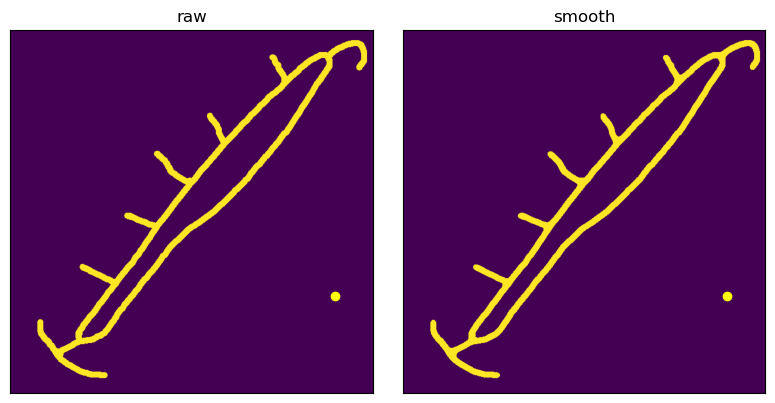

In [117]:
donut = np.pad(donut, pad_width=5, mode='constant', constant_values=0)
point = np.pad(point, pad_width=5, mode='constant', constant_values=0)

point_mask = point != 0
point_coords = center_of_mass(point_mask)

print(f'{point_coords[0]:.2f} {point_coords[1]:.2f}')


fig, axs = plt.subplots(1, 2, figsize = (8,4))
axs[0].set_title('raw')
axs[0].imshow(donut)

########################################
donut = smoothing(donut)
########################################

axs[1].set_title('smooth')
axs[1].imshow(donut)


for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

    ax.scatter(*point_coords[::-1], c = '#ffff00')

plt.tight_layout()

4


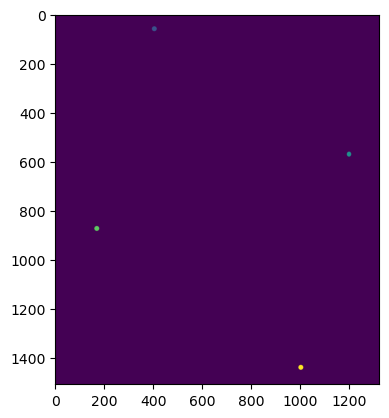

In [16]:
labeled_mark, n_mark = label(points)
print(n_mark)
plt.imshow(labeled_mark)

In [ ]:
marks_df = pd.DataFrame()

mark_coords = []
mark_sizes = []

for l in range(1, n_mark+1):
    current_mark = labeled_mark == l
    current_center = center_of_mass(current_mark)
    mark_coords.append(tuple(float(c) for c in current_center))





marks_df['coords'] = mark_coords



,coords
0,"(59.5, 403.5)"
1,"(570.6041666666666, 1195.5)"
2,"(873.5, 169.5)"
3,"(1439.5, 999.5)"


### get the ventricle

In [118]:
height, width = donut.shape

donut_mask = donut != 0

# we should have only ventricle and outside regions
labeled, n = label(~ donut_mask)

if n != 2:
    raise ValueError('problem with masks, too many regions')

# outside label is the label of the pixel on the top left
outside_label = labeled[(0,0)]
outside_mask = labeled == outside_label
# ventricle is the other region
ventr_mask = (labeled != outside_label) & (~ donut_mask)

center_of_mass(ventr_mask)

(np.float64(256.9591988780787), np.float64(345.2889823823297))

In [119]:
r_df = pd.DataFrame()

## finding the edge

### inside edge pixels

In [120]:
edge_in = find_edge(ventr_mask)

coords_in_np = np.argwhere(edge_in)
coords_in = [c for c in coords_in_np]

### outside edge pixels

In [ ]:
edge_out = find_edge(outside_mask)

coords_out_np = np.argwhere(edge_out).astype(int)
coords_out = [tuple(map(int,c)) for c in coords_out_np]

r_df['p_out'] = coords_out

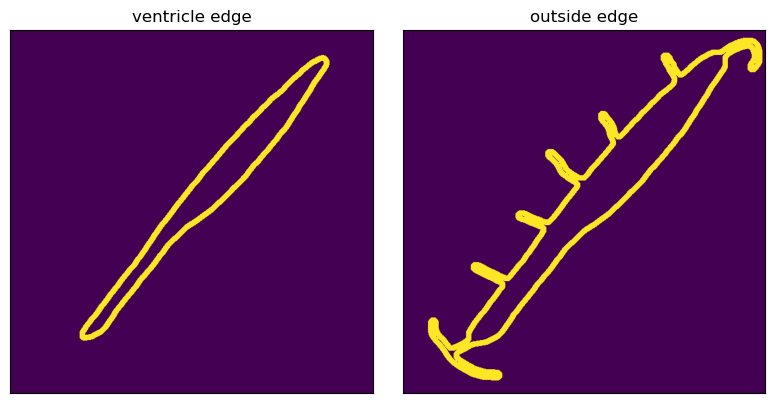

In [124]:
fig, axs = plt.subplots(1,2, figsize = (8,4))

axs[0].set_title('ventricle edge')
axs[0].imshow(thickening(edge_in))

axs[1].set_title('outside edge')
axs[1].imshow(thickening(edge_out))

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

### all the outside pixels have a distance

In [125]:
tissue = np.ma.MaskedArray(~edge_in, outside_mask)

distance = skfmm.distance(tissue, dx=res)

r_df['dist'] = [distance[tuple(c)] for c in r_df['p_out']]

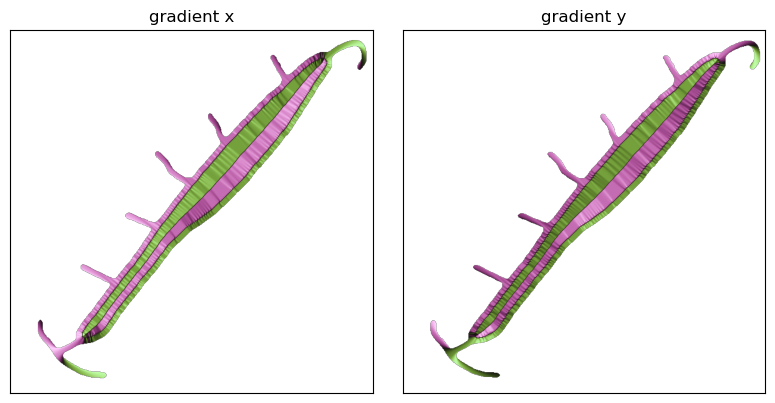

In [126]:
gy, gx = np.gradient(distance)

fig, axs = plt.subplots(1,2, figsize = (8,4))

axs[0].set_title('gradient x')
axs[0].imshow(gx, cmap='vanimo')

axs[1].set_title('gradient y')
axs[1].imshow(gy, cmap='vanimo')

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

## follow the gradient

In [127]:
reference_in_list = []

for i, coord_out in enumerate(tqdm(coords_out_np)):

    coord_in, result_list = follow_gradient(distance, coord_out, edge_in, max_steps=1000)

    reference_in_list.append(coord_in)

r_df['p_in'] = reference_in_list


100%|██████████| 2043/2043 [00:11<00:00, 179.96it/s]


## find the reference angle

In [ ]:
# find center of the ventricle
ventr_coords = center_of_mass(ventr_mask)

# find point in the reference pic
point_mask = point != 0
point_coords = center_of_mass(point_mask)

angle_0 = find_angle(point_coords, ventr_coords)

NameError: name 'ventr_mask' is not defined

In [ ]:
for index, row in r_df.iterrows():
    coord_in = row['p_in']

    current_angle = find_angle(coord_in, ventr_coords)

    r_df.loc[index, 'angle'] = (current_angle / np.pi * 180) % 360


In [130]:
r_df.head(10)

,p_out,dist,p_in,angle
0,"(17, 573)",53.404483,"(49, 530)",91.820070
1,"(17, 574)",54.056931,"(49, 530)",91.820070
2,"(17, 575)",54.793911,"(50, 530)",91.682907
3,"(17, 576)",55.588015,"(49, 530)",91.820070
4,"(17, 577)",56.412378,"(50, 530)",91.682907
5,"(17, 578)",57.252643,"(49, 530)",91.820070
6,"(17, 579)",58.102818,"(49, 530)",91.820070
7,"(17, 580)",58.960885,"(49, 530)",91.820070
8,"(17, 581)",59.826298,"(49, 530)",91.820070
9,"(17, 582)",60.698886,"(50, 530)",91.682907


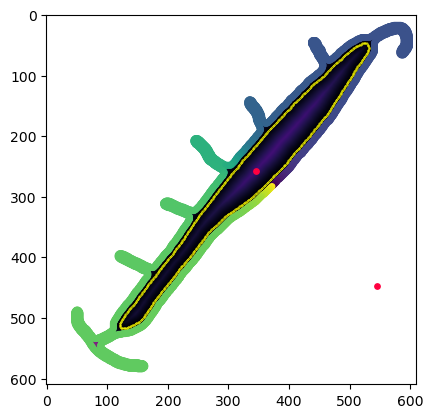

In [131]:
plt.imshow(distance, cmap='magma')
plt.scatter(*df_col_to_points(coords_out), s=15, c=r_df['angle'])
plt.scatter(*df_col_to_points(coords_in), s=0.1, c='yellow')

plt.scatter(*point_coords[1::-1], s=15, color = "#ff0040")
plt.scatter(*ventr_coords[::-1], s=15, color = "#ff0040")

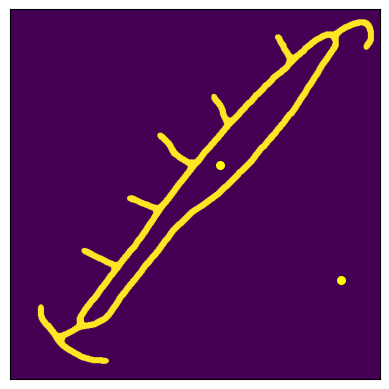

In [132]:
plt.imshow(donut)
plt.xticks([])
plt.yticks([])

plt.scatter(*point_coords[1::-1], s=30, color = "#ffff00")
plt.scatter(*ventr_coords[::-1], s=30, color = "#ffff00")

plt.savefig(f'plots/{name}_show.png')

## comparison

### 1 - angle on the ventricle

In [133]:
# output_angle_df = pd.DataFrame()

# gap = 1

# angles = range(0, 360, gap)
# output_angle_df['angle'] = angles

# # adding a padding to get the angles around the whole circle
# temp_low_padding = r_df.loc[r_df['angle'] > 360-gap].copy()
# temp_low_padding['angle'] = temp_low_padding['angle'] - 360

# temp_upp_padding = r_df.loc[r_df['angle'] < gap].copy()
# temp_upp_padding['angle'] = temp_upp_padding['angle'] + 360


# temp_r_df = pd.concat((r_df, temp_low_padding, temp_upp_padding), ignore_index=True)

# for i, a in enumerate(angles):
#     current_points = temp_r_df.loc[(temp_r_df['angle'] > a - gap) & (temp_r_df['angle'] < a + gap)]

#     output_angle_df.loc[i, 'dist'] = current_points['dist'].mean()


### 2 - unraveling the outside

In [134]:
ordered_edge_out = ordered_edge_points(edge_out)

starting_point_out = r_df.loc[r_df['angle'] == r_df['angle'].min()].iloc[0]['p_out']


i = ordered_edge_out.index(starting_point_out)
ordered_edge_out = ordered_edge_out[i:] + ordered_edge_out[:i]


order_map = {p: i for i, p in enumerate(ordered_edge_out)}
r_df['order_out'] = r_df['p_out'].map(order_map)

In [135]:
# k = 360

# r_df['binned_out'] = pd.cut(r_df['order_out'], bins=k)

# output_perim_df = pd.DataFrame()
# output_perim_df['perc'] = np.arange(k) / k * 100

# output_perim_df['dist'] = (
#     r_df
#     .groupby('binned_out')[['dist']]
#     .mean()
#     .reset_index()
# )['dist']

# output_perim_df['angle'] = (
#     r_df
#     .groupby('binned_out')[['angle']]
#     .mean()
#     .reset_index()
# )['angle']

### 3 - unraveling the ventricle

In [136]:
ordered_edge_in = ordered_edge_points(edge_in)

starting_point_in = r_df.loc[r_df['angle'] == r_df['angle'].min()].iloc[0]['p_in']

i = ordered_edge_in.index(starting_point_in)
ordered_edge_in = ordered_edge_in[i:] + ordered_edge_in[:i]

order_map = {p: i for i, p in enumerate(ordered_edge_in)}
r_df['order_in'] = r_df['p_in'].map(order_map)

In [137]:
r_df['order_in_norm'] = r_df['order_in']/r_df['order_in'].max()
r_df['order_out_norm'] = r_df['order_out']/r_df['order_out'].max()

## finding reference angles

In [138]:
r_df['angle_mark'] = 0
ref_angles = [0, 90, 180, 270]

for ref_angle in ref_angles:
    r_df.loc[(r_df['angle'] - ref_angle).abs().idxmin(), 'angle_mark'] = 1

In [139]:
r_df['angle_mark'].unique()

array([0, 1])

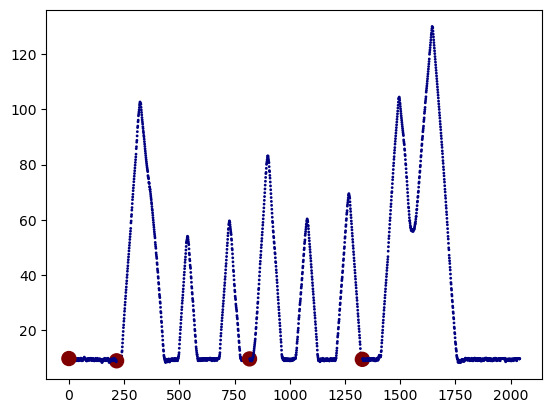

In [140]:
plt.scatter(r_df['order_out'], r_df['dist'], c=r_df['angle_mark'], s = r_df['angle_mark']*100 + 1, cmap='jet')

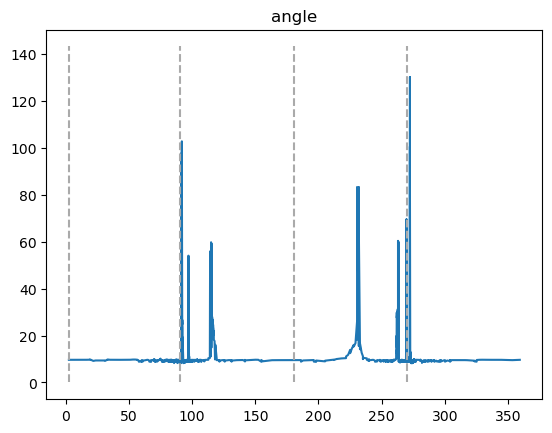

In [ ]:
plot_ordered('angle', 'dist', df = r_df, name=name)

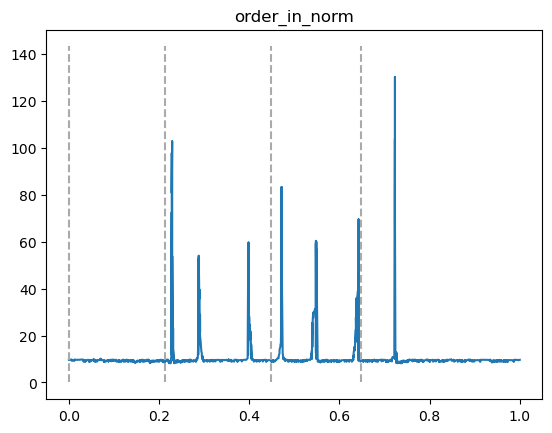

In [ ]:
plot_ordered('order_in_norm', 'dist', df = r_df, name=name)

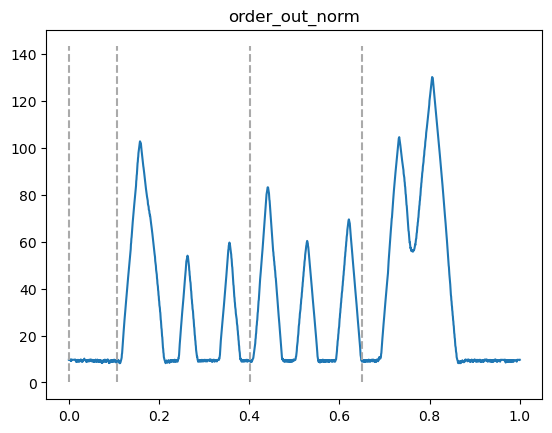

In [ ]:
plot_ordered('order_out_norm', 'dist', df = r_df, name=name)

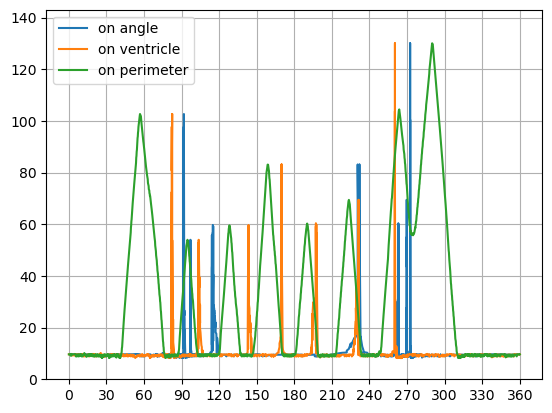

In [ ]:
plt.title('')

r_df_sorted = r_df.sort_values(by='angle')
plt.plot(r_df_sorted['angle'], r_df_sorted['dist'], label='on angle')

r_df_sorted = r_df.sort_values(by='order_in')
plt.plot(r_df_sorted['order_in_norm']*360, r_df_sorted['dist'], label='on ventricle')

r_df_sorted = r_df.sort_values(by='order_out')
plt.plot(r_df_sorted['order_out_norm']*360, r_df_sorted['dist'], label='on perimeter')


plt.ylim(0, r_df['dist'].max()*1.1)
plt.legend()
plt.xticks(np.arange(0,390,30))
plt.grid()

plt.savefig(f'plots/{name}_comparison.png')

In [148]:
r_df.to_csv('test.csv')

# summary

In [ ]:
def analyze_thick(donut, medial_point, res, smooth = True):
    # padding to avoid edge problems
    donut = np.pad(donut, pad_width=5, mode='constant', constant_values=0)
    medial_point = np.pad(medial_point, pad_width=5, mode='constant', constant_values=0)

    point_mask = point != 0
    point_coords = center_of_mass(point_mask)

    if smooth:
        donut = smoothing(donut)
    

    donut_mask = donut != 0

    # we should have only ventricle and outside regions
    labeled, n = label(~ donut_mask)

    if n != 2:
        raise ValueError('problem with masks, too many regions')

    # outside label is the label of the pixel on the top left
    outside_label = labeled[(0,0)]
    outside_mask = labeled == outside_label
    # ventricle is the other region
    ventr_mask = (labeled != outside_label) & (~ donut_mask)


    r_df = pd.DataFrame()

    # inside edge
    edge_in = find_edge(ventr_mask)
    coords_in_np = np.argwhere(edge_in)
    coords_in = [c for c in coords_in_np]

    # outside edge
    edge_out = find_edge(outside_mask)
    coords_out_np = np.argwhere(edge_out).astype(int)
    coords_out = [tuple(map(int,c)) for c in coords_out_np]
    r_df['p_out'] = coords_out

    # distance
    tissue = np.ma.MaskedArray(~edge_in, outside_mask)
    distance = skfmm.distance(tissue, dx=res)
    r_df['dist'] = [distance[tuple(c)] for c in r_df['p_out']]

    # from outside pixel to inside reference
    reference_in_list = []
    for i, coord_out in enumerate(tqdm(coords_out_np)):
        coord_in, result_list = follow_gradient(distance, coord_out, edge_in, max_steps=1000)
        reference_in_list.append(coord_in)
    r_df['p_in'] = reference_in_list


    # find center of the ventricle
    ventr_coords = center_of_mass(ventr_mask)

    # find point in the reference pic
    point_mask = point != 0
    point_coords = center_of_mass(point_mask)

    angle_0 = find_angle(point_coords, ventr_coords)
    # from inside pixel to angle
    for index, row in r_df.iterrows():
        coord_in = row['p_in']
        current_angle = find_angle(coord_in, ventr_coords)
        r_df.loc[index, 'angle'] = (current_angle / np.pi * 180) % 360
    
    
    # unravel the outside perimeter
    ordered_edge_out = ordered_edge_points(edge_out)
    starting_point_out = r_df.loc[r_df['angle'] == r_df['angle'].min()].iloc[0]['p_out']

    i_out = ordered_edge_out.index(starting_point_out)
    ordered_edge_out = ordered_edge_out[i_out:] + ordered_edge_out[:i_out]

    order_map = {p: i for i, p in enumerate(ordered_edge_out)}
    r_df['order_out'] = r_df['p_out'].map(order_map)
    r_df['order_out_norm'] = r_df['order_out']/r_df['order_out'].max()


    # unravel the inside perimeter
    ordered_edge_in = ordered_edge_points(edge_in)
    starting_point_in = r_df.loc[r_df['angle'] == r_df['angle'].min()].iloc[0]['p_in']

    i_in = ordered_edge_in.index(starting_point_in)
    ordered_edge_in = ordered_edge_in[i_in:] + ordered_edge_in[:i_in]

    order_map = {p: i for i, p in enumerate(ordered_edge_in)}
    r_df['order_in'] = r_df['p_in'].map(order_map)
    r_df['order_in_norm'] = r_df['order_in']/r_df['order_in'].max()

    # reference angles
    r_df['angle_mark'] = 0
    ref_angles = [0, 90, 180, 270]

    for ref_angle in ref_angles:
        r_df.loc[(r_df['angle'] - ref_angle).abs().idxmin(), 'angle_mark'] = 1
    

    return r_df

In [3]:
tissue, _ = get_picture2D('test_vent.tif')
res = (1,1)

point = np.zeros_like(tissue).astype(bool)
test_coord = (point.shape[0] // 2, point.shape[1] - 1)
point[test_coord] = True

df = analyze_thick(tissue, point, res)

c:\Users\USUARIO\anaconda3\envs\image-env\Lib\site-packages\aicsimageio\readers\tiff_reader.py:148: UserWarning: Could not parse tiff pixel size: 'unit'
  warnings.warn(f"Could not parse tiff pixel size: {e}")


smoothing factor = 4.56


100%|██████████| 1239/1239 [00:04<00:00, 297.34it/s]


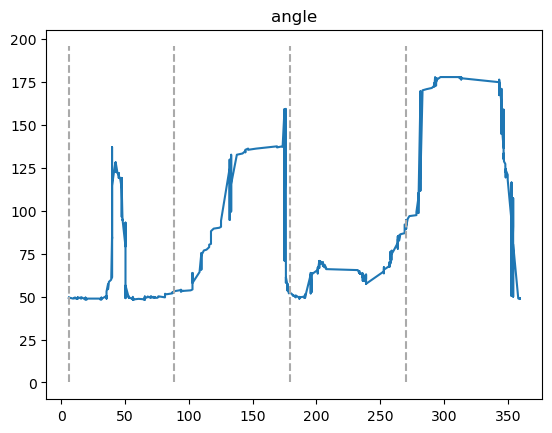

In [5]:
plot_ordered('angle', 'dist', df = df)

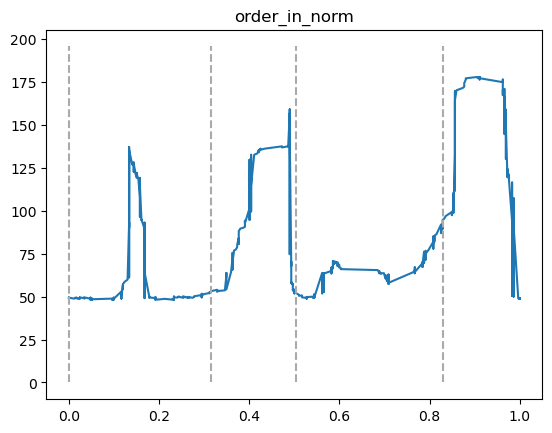

In [7]:
plot_ordered('order_in_norm', 'dist', df = df)

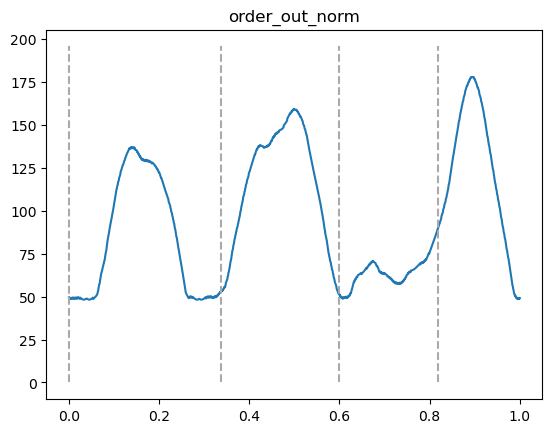

In [6]:
plot_ordered('order_out_norm', 'dist', df = df)